In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import erf
from scipy.optimize import minimize
import jax
from jax import grad
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import time
from IPython.display import display, clear_output
from gp_utils import *

### 1D Gaussian Process

The latent joint distribution of training outputs $\mathbf{y}$ and a test function value $f_* = f(\mathbf{x}_*)$ is:
$$
\begin{bmatrix} \mathbf{y} \\ f_* \end{bmatrix}
\sim \mathcal{N} \left(
\begin{bmatrix} m(\mathbf{X}) \\ m(\mathbf{x}_*) \end{bmatrix},
\begin{bmatrix}
K(\mathbf{X}, \mathbf{X}) + \sigma_n^2 I & K(\mathbf{X}, \mathbf{x}_*) \\
K(\mathbf{x}_*, \mathbf{X}) & K(\mathbf{x}_*, \mathbf{x}_*)
\end{bmatrix}
\right).
$$

The posterior mean function is:

 - $
 \begin{aligned}
\boldsymbol{\mu}_{\mathbf{f}_* | \mathbf{y}} 
&= \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1)\\ 
&= m(\mathbf{x}_*) + K(\mathbf{x}_*, \mathbf{X}) [K(\mathbf{X}, \mathbf{X}) + \sigma_n^2 I]^{-1} (\mathbf{y} - m(\mathbf{X})).
\end{aligned}
$

The posterior covariance function is:
 - $
 \begin{aligned}
\Sigma_{\mathbf{f}_* | \mathbf{y}} 
&= \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}\\ 
&= K(\mathbf{x}_*, \mathbf{x}_*) - K(\mathbf{x}_*, \mathbf{X}) [K(\mathbf{X}, \mathbf{X}) + \sigma_n^2 I]^{-1} K(\mathbf{X}, \mathbf{x}_*).
\end{aligned}
$

---

The marginal likelihood for a GP is given by (equation 2.30 of RW)

$$
\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^T(K(X,X)+\sigma_\epsilon^2I)^{-1}\mathbf{y} -\frac{1}{2}\log\:\left|K(X,X)+\sigma_\epsilon^2I\right| - \frac{N}{2}\log 2\pi,
$$

where $\theta = (\sigma^2, l^2)$ are the hyperparameters of the covariance function $k$

---

A popular covariance function is the squared exponential covariance function (a.k.a. a radial-basis function or an exponential quadratic covariance function):

$$
\text{cov}(f(\mathbf{x}),f(\mathbf{x}^\prime)) = k(\mathbf{x}, \mathbf{x}^\prime) = \sigma^2\exp\left\{-\frac{1}{2l^2}\left|\mathbf{x}-\mathbf{x}^\prime\right|^2\right\}
$$

In [2]:
def common_components(
    x, y, s, L, 
    m0=None, x_m=None, w=None, 
    new_k=True):
    x = jnp.atleast_2d(x).astype(jnp.float64)
    if x.shape[0] == 1 and x.shape[1] > 1:
        x = x.T
    y = jnp.atleast_2d(y).reshape(-1, 1)
    n = x.shape[0]

    L = jnp.diag(L)

    if m0 is None:
        m0 = jnp.mean(y)
        x_m = jnp.mean(x, axis=0)
        w = (jnp.max(x, axis=0) - jnp.min(x, axis=0))/5.0
        w = 2

    x_m = jnp.asarray(x_m).reshape(-1)
    w = jnp.asarray(w).reshape(-1)
    m = m0 - 0.5*jnp.sum(((x - x_m)/w) ** 2, axis=1, keepdims=True)
    

    if new_k:

        Kxx = rbf(x, x, s, L) + 1e-10 * jnp.eye(n)
        chol_k = jnp.linalg.cholesky(Kxx)
        return x,y,L,m0,x_m,w,m,chol_k
    else:
        return x,y,L,m0,x_m,w,m
    


def gp_predict(
        xs, ys, x_eval, 
        s,L,m0,x_m,w, m,
        chol_k=None, K_inv=None, old_K=False
        ):
    x_eval = x_eval.reshape(-1, x_m.shape[0])
    M = m0 - 0.5*jnp.sum(((x_eval - x_m)**2)/(w**2), axis=1)



    K_s = rbf(xs, x_eval, s, L)
    K_ss = rbf(x_eval, x_eval, s, L)

    #rank one update is old_k
    if old_K:
        n_old = K_inv.shape[0]
        K12 = rbf(xs[:n_old], xs[n_old:], s, L)
        K21 = K12.T
        K22 = rbf(xs[n_old:], xs[n_old:], s, L)

        # Schur complement
        S = K22 - K21 @ K_inv @ K12
        chol_S = jnp.linalg.cholesky(S + 1e-10 * jnp.eye(S.shape[0]))

        def solve_S(b):
            return jax.scipy.linalg.cho_solve((chol_S, True), b)

        # Updated inverse blocks
        top_left = K_inv + K_inv @ K12 @ solve_S(K21 @ K_inv)
        top_right = -K_inv @ K12 @ solve_S(jnp.eye(K22.shape[0]))
        bottom_left = -solve_S(K21 @ K_inv)
        bottom_right = solve_S(jnp.eye(K22.shape[0]))

        # Assemble updated inverse
        K_inv = jnp.block([
            [top_left, top_right],
            [bottom_left, bottom_right]
        ])
    else:
        #normal update if 
        K_inv = jax.scipy.linalg.cho_solve((chol_k, True), jnp.eye(chol_k.shape[0]))

    # Compute mean and covariance
    ym = ys - m

    mu = M + (K_s.T @ K_inv @ ym).ravel()
    sig = K_ss - K_s.T @ K_inv @ K_s + 1e-9 * jnp.eye(K_ss.shape[0])

    return mu.ravel(), sig, K_inv


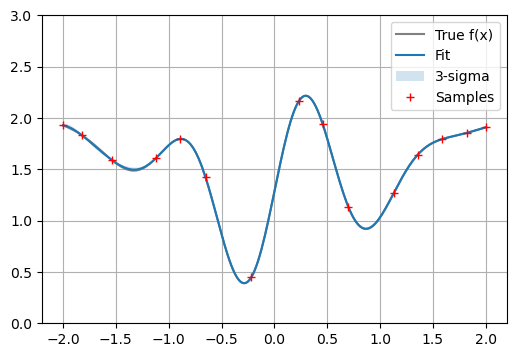

In [3]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2.0
upper = 2.0

# Sample points for the demonstration
n_total = 15

x_eval = jnp.linspace(lower, upper, 250)

# Start with empty dataset and add points one by one
x_data = jnp.array([])
y_data = jnp.array([])

chol_k = None

x1 = jnp.array(np.random.uniform(lower, upper))
x_data = jnp.append(x_data, x1)
y_data = jnp.append(y_data, f(x1))

s = 12
L = jnp.array([0.6])
for i in range(n_total):

    #compute GP posterior   
    if i == 0: 
        x1,y1,L1,m01,x_m1,w1,m1,chol_k1 = common_components(
            x_data, y_data, s=s, L=L, 
            m0=None, x_m=None, w=None, 
            new_k=True
            )
        mu_eval, var_eval, K_inv = gp_predict(
            x1, y1, x_eval,
            s=s,L=L1,
            m0=m01,x_m=x_m1,w=w1,m=m1,
            chol_k=chol_k1, K_inv=None, old_K=False)
    else:
        x1,y1,L1,m01,x_m1,w1,m1 = common_components(
            x_data, y_data, s=s, L=L, 
            m0=m01, x_m=x_m1, w=w1, 
            new_k=False
            )
        mu_eval, var_eval, K_inv = gp_predict(
            x1, y1, x_eval,
            s=s,L=L1,
            m0=m01,x_m=x_m1,w=w1,m=m1,
            chol_k=None, K_inv=K_inv, old_K=True)


    sig_diag = jnp.sqrt(jnp.diag(var_eval))
    

    #real curve
    plt.figure(figsize=(6,4))
    plt.plot(x_eval, f(x_eval), color='gray', label='True f(x)')

    #fit
    plt.plot(x_eval, mu_eval, label='Fit')
    plt.fill_between(x_eval, mu_eval-2*sig_diag, mu_eval+2*sig_diag, alpha=0.2, label='3-sigma')
    plt.plot(x_data, y_data, '+', color='red', label='Samples')
    
    plt.ylim(0,3)
    plt.grid()
    plt.legend()
    
    display(plt.gcf())
    time.sleep(1.0)
    clear_output(wait=True)
    plt.close()

    if i < n_total - 1:
        #Add next point
        x1 = x_eval[jnp.argmax(jnp.diag(var_eval))]
        x_data = jnp.append(x_data, x1)
        y_data = jnp.append(y_data, f(x1))


### 2D Gaussian Process

Relative Humidity is a function of temperature and dew point.

$$
e_s(T) = 6.1121 \, \exp\left(\left(18.678 - \frac{T}{234.5}\right) \cdot \left(\frac{T}{257.14 + T}\right)\right) \\

e = 6.1121 \, \exp\left(\left(18.678 - \frac{T_d}{234.5}\right) \cdot \left(\frac{T_d}{257.14 + T_d}\right)\right) \\
$$
$$
RH = 100 \times \frac{e}{e_s(T)}
$$

In [4]:
def RH(T, Td):
    eT = 6.1121*jnp.exp((18.678 - T/234.5)*(T/(257.14 + T)))
    eTd = 6.1121*jnp.exp((18.678 - Td/234.5)*(Td/(257.14 + Td)))
    return 100*eTd/eT

The marginal likelihood for a GP is given by (equation 2.30 of RW)

$$
\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^T(K(X,X)+\sigma_\epsilon^2I)^{-1}\mathbf{y} -\frac{1}{2}\log\:\left|K(X,X)+\sigma_\epsilon^2I\right| - \frac{N}{2}\log 2\pi,
$$

where $\theta = (\sigma^2, l^2)$ are the hyperparameters of the covariance function $k$

Optimised params: [10.          7.96970524  8.17547278]
Optimised log marginal likelihood: -4968.967720480404
For Temp: 27.6°C and DewP: 23.0°C
--------------------------------------
Relative humidity1 is: 76.3918%
The gp estimate is: 77.0855%
Error: 0.6937
95% CI: [77.0496%, 77.1214%]



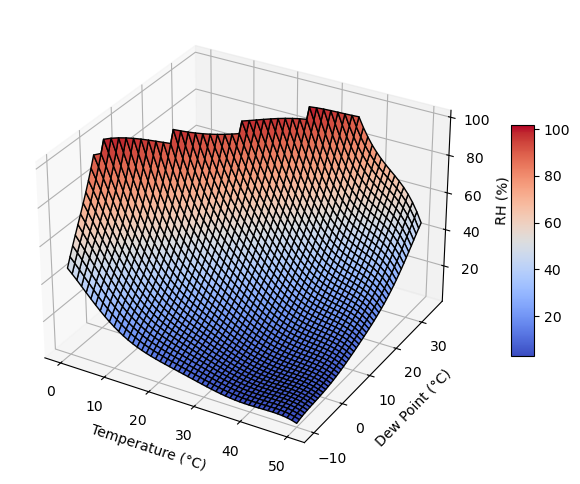

In [8]:
#training data points
Temp = jnp.linspace(0,50,6)
DewP = jnp.linspace(-10,35,6)
T, D = jnp.meshgrid(Temp, DewP)
TD = jnp.column_stack([T.ravel(), D.ravel()])
rh = RH(TD[:,0], TD[:,1])


#evaluation points
Temp_eval = jnp.linspace(0,50,50)
DewP_eval = jnp.linspace(-10,35,50)
T_eval, D_eval = jnp.meshgrid(Temp_eval, DewP_eval)
TD_eval = jnp.column_stack([T_eval.ravel(), D_eval.ravel()])


grad_fn = grad(neg_gp_likelihood)
s_init = 5.0
#diagonal L
l_init = jnp.array([7.0, 7.0])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])


res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, TD, rh, rbf)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, TD, rh, rbf)),
    method="L-BFGS-B",
    bounds=[(2, 10)] * len(init_params)
)

print("Optimised params:", res.x)
print("Optimised log marginal likelihood:", -res.fun)



#fit GP
s = res.x[0]
L = res.x[1:]*2.5

x1,y1,L1,m01,x_m1,w1,m1,chol_k1 = common_components(
    TD, rh, s=s, L=L, 
    m0=None, x_m=None, w=None, 
    new_k=True
    )

mu_grid, var_eval, K_inv = gp_predict(
    x1, y1, TD_eval,
    s=s,L=L1,
    m0=m01,x_m=x_m1,w=w1,m=m1,
    chol_k=chol_k1, K_inv=None, old_K=False)

#mu_grid, var_grid, kinv = gp_predict(TD, rh, TD_eval, kernel=rbf, s=s, L=L)
mu_grid = mu_grid.reshape(T_eval.shape)
mu_grid = np.where(D_eval > T_eval, jnp.nan, mu_grid)


#calculate relative humidity at random point
T = np.random.uniform(0,50,1)[0]
D = np.random.uniform(-10,T,1)[0]
td_eval = jnp.array([[T, D]])
relhum = RH(T,D)


#predict at same random point
#gp_est, gp_var, kinv = gp_predict(TD, rh, td_eval, kernel=rbf, s=s, L=L)
gp_est, gp_var, K_inv = gp_predict(
    x1, y1, td_eval,
    s=s,L=L1,
    m0=m01,x_m=x_m1,w=w1,m=m1,
    chol_k=chol_k1, K_inv=None, old_K=False)
low = gp_est - 1.96*jnp.sqrt(gp_var)
high = gp_est + 1.96*jnp.sqrt(gp_var)
error = np.abs(relhum - gp_est)


print(f'For Temp: {T:.1f}°C and DewP: {D:.1f}°C')
print('--------------------------------------')
print(f'Relative humidity1 is: {relhum:.4f}%')
print(f'The gp estimate is: {gp_est[0]:.4f}%')

print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}%, {high[0][0]:.4f}%]')
print()

#plot of GP surface
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_eval, D_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Dew Point (°C)')
ax.set_zlabel('RH (%)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()
